In [1]:
# Cálcula el porcentaje de error entre dos series de máximos anuales.

import itertools
import os

import numpy as np
import pandas as pd
import xarray as xr

from matplotlib import pyplot as plt

import statsmodels.api        as sm
import statsmodels.stats.api  as sms

In [2]:
# Cantidad de celdas a eliminar del borde.
k = 1

# Archivos a evaluar.
eval = [ [0, 2], [0, 7], [4, 5], [5, 6], [8, 6], [9, 10], [11, 12], [13, 14] ]
n = 7
i = eval[n][0]
j = eval[n][1]
var = "wenzel"
#var = "medido"

name = [ "CHIRPS_interp_WRF", "CHIRPS_megalopolis", "prec_era5_hist_hist_days",
    "prec_hist_comp_estaciones", "prec_era5_hist_hist",
    "prec_mroc_hist_hist", "prec_mroc_2040_2040",
    "prec_mroc_hist_hist_days", "prec_mroc_h20a_hist",
    "prec_mroc_h20a_hist_coarsen_5", "prec_mroc_2040_2040_coarsen_5",
    "WRF_regrid_CHIRPS_days_qmap", "WRF_2040_regrid_CHIRPS_days_qmap",
    "WRF_regrid_ERA5_1985_2014_qmap", "WRF_regrid_ERA5_2040_2059_qmap" ]

fname = f"{name[i]}_{name[j]}"
temp_d = "../../../temp/cc_idt/"
dir = f"{temp_d}comp/{fname}/"

# Si no existe la carpeta, la crea.
if not os.path.exists(f"{temp_d}comp/"): os.mkdir(f"{temp_d}comp/")
if not os.path.exists(dir): os.mkdir(dir)

if var == "wenzel":
    path_orig   = f"{temp_d}SAM/{name[i]}/{name[i]}_idf_valores.nc" 
    path_comp   = f"{temp_d}SAM/{name[j]}/{name[j]}_idf_valores.nc" 
if var == "medido":
    path_orig   = f"{temp_d}SAM/{name[i]}/{name[i]}_tretorno.nc" 
    path_comp   = f"{temp_d}SAM/{name[j]}/{name[j]}_tretorno.nc" 
path_orig_s = f"{temp_d}SAM/{name[i]}/{name[i]}_stats.nc" 
path_comp_s = f"{temp_d}SAM/{name[j]}/{name[j]}_stats.nc" 

ds_orig   = xr.open_dataset(path_orig  )
ds_comp   = xr.open_dataset(path_comp  )
orig_stat = xr.open_dataset(path_orig_s)
comp_stat = xr.open_dataset(path_comp_s)

if k != 0:
    ds_orig   =   ds_orig.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} )
    ds_comp   =   ds_comp.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} )    
    orig_stat = orig_stat.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} )
    comp_stat = comp_stat.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} ) 

vars = ["count", "mean", "std", "min", "25%", "50%", "75%", "max"]

# Estadísticas de los valores originales.
ds_orig.to_dataframe()[["INTENSIDAD"]].describe()

,INTENSIDAD
count,1.017900e+05
mean,1.225084e+06
std,5.593670e+06
min,-2.385248e-14
25%,7.608663e+02
50%,1.857237e+03
75%,1.163876e+05
max,1.772561e+08


In [3]:
ds_orig

<xarray.Dataset> Size: 815kB
Dimensions:         (LONGITUD: 39, LATITUD: 29, DURACION: 9, TIEMPO_RETORNO: 10)
Coordinates:
  * LONGITUD        (LONGITUD) float64 312B -100.9 -100.8 -100.7 ... -97.2 -97.1
  * LATITUD         (LATITUD) float64 232B 18.1 18.2 18.3 ... 20.7 20.8 20.9
  * DURACION        (DURACION) float64 72B 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0
  * TIEMPO_RETORNO  (TIEMPO_RETORNO) float64 80B 1.0 2.0 5.0 ... 500.0 1e+03
Data variables:
    INTENSIDAD      (LONGITUD, LATITUD, DURACION, TIEMPO_RETORNO) float64 814kB ...

In [4]:
ds_comp

<xarray.Dataset> Size: 815kB
Dimensions:         (LONGITUD: 39, LATITUD: 29, DURACION: 9, TIEMPO_RETORNO: 10)
Coordinates:
  * LONGITUD        (LONGITUD) float64 312B -100.9 -100.8 -100.7 ... -97.2 -97.1
  * LATITUD         (LATITUD) float64 232B 18.1 18.2 18.3 ... 20.7 20.8 20.9
  * DURACION        (DURACION) float64 72B 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0
  * TIEMPO_RETORNO  (TIEMPO_RETORNO) float64 80B 1.0 2.0 5.0 ... 500.0 1e+03
Data variables:
    INTENSIDAD      (LONGITUD, LATITUD, DURACION, TIEMPO_RETORNO) float64 814kB ...

In [5]:
# Error total de las estadísticas mensuales.
E = 3
est_n = ["del mínimo", "del máximo",
    "de la media", "de la desviación estándar"]
error_s = ( ( comp_stat - orig_stat ) / orig_stat
    ).rename( {"PRECIPITACION": "P_ERROR"} )
error_s.to_netcdf(dir + fname + "_stats.nc")
df_e = error_s.to_dataframe()

tot = [ error_s.sel(ESTADISTICA = E)["P_ERROR"].count(       ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].mean(        ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].std(         ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].min(         ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].quantile(0.25).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].quantile(0.5 ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].quantile(0.75).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].max(         ).values + 0 ]

print(f"Errores {est_n[E - 1]} mensual entre {name[i]} y {name[j]}")
for l in range( len(vars) ): print(f"{vars[l]}: {tot[l]:.2f}")

Errores de la media mensual entre WRF_regrid_ERA5_1985_2014_qmap y WRF_regrid_ERA5_2040_2059_qmap
count: 13452.00
mean: 0.03
std: 0.29
min: -0.66
25%: -0.14
50%: 0.02
75%: 0.15
max: 1.31


In [6]:
# Error en el total de precipitación.
prec_e = ( comp_stat.to_dataframe().xs(E, level = 3
    ).groupby(["LATITUD", "LONGITUD"]).sum()
    / orig_stat.to_dataframe().xs(E, level = 3
    ).groupby(["LATITUD", "LONGITUD"]).sum() - 1 )

prec_e.describe()

,PRECIPITACION
count,1121.000000
mean,0.001366
std,0.009750
min,-0.030946
25%,-0.001454
50%,0.000166
75%,0.003186
max,0.056085


In [7]:
# Error total.
if var == "medido":
    ds_comp = ds_comp.drop_vars( ["AÑO", "PROBABILIDAD"] )
    ds_orig = ds_orig.drop_vars( ["AÑO", "PROBABILIDAD"] )
error = ( ( ds_comp - ds_orig )
    / ds_orig ).rename( {"INTENSIDAD": "P_ERROR"} )
#error = ( ( ds_comp.drop( ["AÑO", "PROBABILIDAD"] )
#    - ds_orig.drop( ["AÑO", "PROBABILIDAD"] ) )
#    / ds_orig ).rename( {"INTENSIDAD": "P_ERROR"} )
error.to_netcdf(dir + fname + ".nc")
df_e = error.to_dataframe()

tot = [ error["P_ERROR"].count(       ).values + 0,
        error["P_ERROR"].mean(        ).values + 0,
        error["P_ERROR"].std(         ).values + 0,
        error["P_ERROR"].min(         ).values + 0,
        error["P_ERROR"].quantile(0.25).values + 0,
        error["P_ERROR"].quantile(0.5 ).values + 0,
        error["P_ERROR"].quantile(0.75).values + 0,
        error["P_ERROR"].max(         ).values + 0 ]

print(f"Errores entre {name[i]} y {name[j]}")
for l in range( len(vars) ): print(f"{vars[l]}: {tot[l]:.2f}")

Errores entre WRF_regrid_ERA5_1985_2014_qmap y WRF_regrid_ERA5_2040_2059_qmap
count: 101790.00
mean: 149.05
std: 2313.60
min: -1.00
25%: -0.21
50%: 0.02
75%: 0.67
max: 157427.64


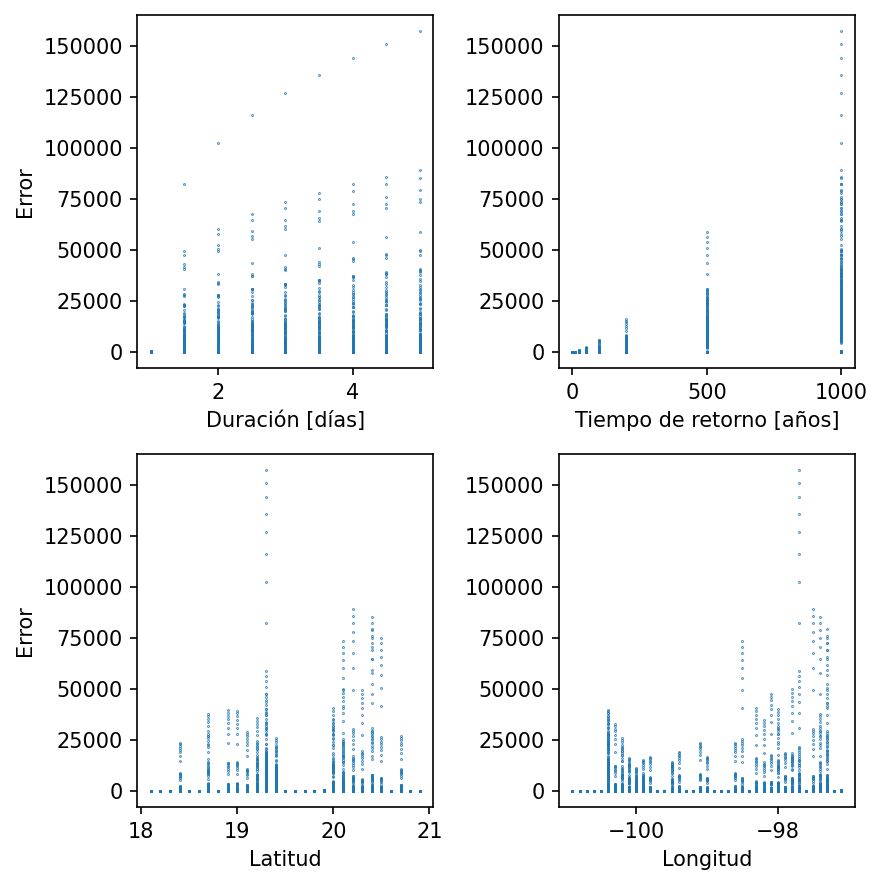

In [8]:
# Grafica de dispersión del error.

# Incializamos gráfica.
fig, ax = plt.subplots(2, 2)
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos.
ax[0, 0].scatter( df_e.reset_index()["DURACION"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )
ax[0, 1].scatter( df_e.reset_index()["TIEMPO_RETORNO"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )
ax[1, 0].scatter( df_e.reset_index()["LATITUD"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )
ax[1, 1].scatter( df_e.reset_index()["LONGITUD"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )

# Nombre de ejes.
ax[0, 0].set_xlabel(f"Duración [días]")
ax[0, 1].set_xlabel(f"Tiempo de retorno [años]")
ax[1, 0].set_xlabel(f"Latitud")
ax[1, 1].set_xlabel(f"Longitud")
ax[0, 0].set_ylabel("Error")
ax[1, 0].set_ylabel("Error")

fig.tight_layout()
plt.show()

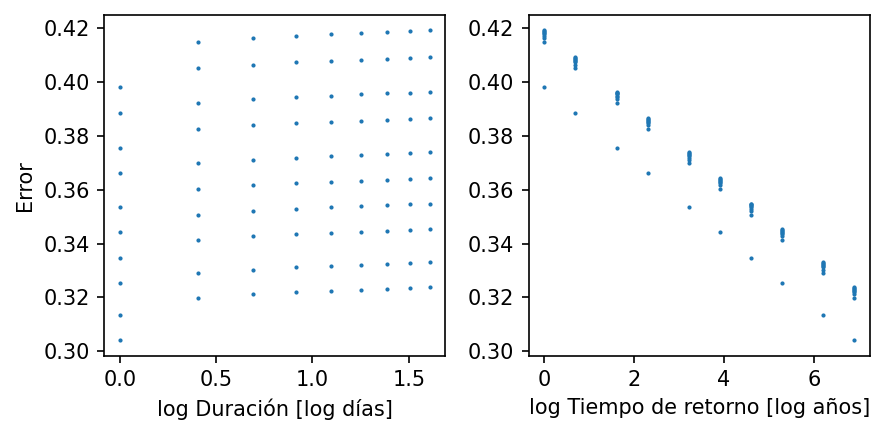

In [9]:
# Grafica de dispersión del error para una celda en particular.

# Incializamos gráfica.
fig, ax = plt.subplots(1,2)
fig.set_facecolor("w")
fig.set_size_inches(6, 3)
fig.set_dpi(150) 

# Seleccionamos una latitud y longitud
W = 5
N = 5
lat = df_e.index.get_level_values("LATITUD").unique()[N]
lon = df_e.index.get_level_values("LONGITUD").unique()[W]
df_xs = df_e.xs( ( lat, lon ), level = ("LATITUD", "LONGITUD") )

# Graficamos.
#ax[0].scatter( f_xs.reset_index()["DURACION"],
#    df_xs.reset_index()["P_ERROR"], s = 1 )
ax[0].scatter( np.log( df_xs.reset_index()["DURACION"] ),
    df_xs.reset_index()["P_ERROR"], s = 1 )
#ax[1].scatter( df_xs.reset_index()["TIEMPO_RETORNO"],
#    df_xs.reset_index()["P_ERROR"], s = 1 )
ax[1].scatter( np.log( df_xs.reset_index()["TIEMPO_RETORNO"] ),
    df_xs.reset_index()["P_ERROR"], s = 1 )

# Nombre de ejes.
#ax[0].set_xlabel(f"Duración [días]")
ax[0].set_xlabel(f"log Duración [log días]")
ax[0].set_ylabel("Error")
#ax[1].set_xlabel(f"Tiempo de retorno [años]")
ax[1].set_xlabel(f"log Tiempo de retorno [log años]")

fig.tight_layout()
plt.show()

In [10]:
# Probamos variables para la regresión.

# Posibles variables.
df_reg = df_xs.reset_index()
df_reg["D_1"] = np.log(  df_reg["DURACION"] )
df_reg["D_2"] = np.sqrt( df_reg["DURACION"] )
df_reg["D_3"] = df_reg["DURACION"] ** 2
df_reg["D_4"] = df_reg["DURACION"] ** 3
df_reg["D_5"] = df_reg["DURACION"] ** 4
df_reg["D_6"] = df_reg["DURACION"] ** 5
df_reg["T_1"] = np.log(  df_reg["TIEMPO_RETORNO"] )
df_reg["T_2"] = np.sqrt( df_reg["TIEMPO_RETORNO"] )
df_reg["T_3"] = df_reg["TIEMPO_RETORNO"] ** 2
df_reg["T_4"] = df_reg["TIEMPO_RETORNO"] ** 3
df_reg["T_5"] = df_reg["TIEMPO_RETORNO"] ** 4
df_reg["T_6"] = df_reg["TIEMPO_RETORNO"] ** 5


# Predictando.
Y = df_reg["P_ERROR"]
# Predictores.
X = sm.add_constant( df_reg[ [  
                              #"DURACION",
                              #"TIEMPO_RETORNO",
                              "D_1",
                              #"D_2",
                              #"D_3",
                              #"D_4",
                              #"D_5",
                              #"D_6",
                              "T_1",
                              #"T_2",
                              #"T_3",
                              #"T_4",
                              #"T_5",
                              #"T_6",
                              ] ] )

# Regresión.
sm.OLS(Y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                P_ERROR   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     3435.
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           1.67e-83
Time:                        12:11:11   Log-Likelihood:                 381.99
No. Observations:                  90   AIC:                            -758.0
Df Residuals:                      87   BIC:                            -750.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4053      0.001    403.927      0.000       0.403       0.407
D_1            0.0098      0.001     13.263      0.000       0.008       0.011
T_1           -0.0138      0.000    -81.822      0.000      -0.014      -0.013
==============================================================================
Omnibus:                        3.610   Durbin-Watson:                   0.135
Prob(Omnibus):                  0.165   Jarque-Bera (JB):                3.592
Skew:                          -0.473   Prob(JB):                        0.166
Kurtosis:                       2.747   Cond. No.                         13.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
# Intentamos obtener un valor para todo el dominio.

# Error normalizado
#error_n = ( error / error.sel(DURACION = 1, TIEMPO_RETORNO = 5 )
#    ).to_dataframe().droplevel(level = (0, 1) ).reset_index()
# Error sin normalizar.
error_n = df_e.copy().reset_index()

# Regresión múltiple logarítmica.
X = sm.add_constant( np.log( error_n[["DURACION", "TIEMPO_RETORNO"]] ) )
Y = error_n[["P_ERROR"]]
model = sm.OLS(Y,X)
results = model.fit()
# Ajuste de la regresión.
results.rsquared_adj

0.008363005156481917

In [12]:
# Hace la regresión lineal para cada celda del archivo.

# Estadísticos a guardar.
cols = [ "CONST",
        "C_LOG_DUR",
        "C_LOG_TRET",
        #"C_SQRT_DUR", "C_SQRT_TRET",
        #"C_2_DUR", "C_2_TRET",
        #"C_3_DUR", "C_3_TRET",
        #"C_DUR",
        #"C_TRET",
        "P_CONST",
        "P_LOG_DUR",
        "P_LOG_TRET",
        #"P_SQRT_DUR", "P_SQRT_TRET",
        #"P_2_DUR", "P_2_TRET",
        #"P_3_DUR", "P_3_TRET",
        #"P_DUR",
        #"P_TRET",
        "ADJ_R_SQUARED", "P_F_STAT", "P_JB", "COND_NO", "P_BP" ]
# Creamos la tabla con los estadísticos.
df_s = pd.DataFrame( np.array( list( itertools.product(
    df_e.index.get_level_values("LATITUD").unique(),
    df_e.index.get_level_values("LONGITUD").unique() ) ) ),
    columns = ["LATITUD", "LONGITUD"] )
df_s[cols] = None
df_s = df_s.set_index( ["LATITUD", "LONGITUD"] )

# Iteramos para cada celda.
for lat in df_e.index.get_level_values("LATITUD").unique():
    for lon in df_e.index.get_level_values("LONGITUD").unique():
        
        # Seleccionamos la celda.
        df_xs = df_e.xs( ( lat, lon ),
            level = ("LATITUD", "LONGITUD") ).reset_index()
        # Calculamos el logaritmo de la duración.
        df_xs["LOG_DURACION"] = np.log( df_xs["DURACION"] )
        df_xs["LOG_TRETORNO"] = np.log( df_xs["TIEMPO_RETORNO"] )
        #df_xs["SQRT_DURACION"] = np.sqrt( df_xs["DURACION"] )
        #df_xs["SQRT_TRETORNO"] = np.sqrt( df_xs["TIEMPO_RETORNO"] )
        #df_xs["2_DURACION"] = df_xs["DURACION"] ** 2
        #df_xs["2_TRETORNO"] = df_xs["TIEMPO_RETORNO"] ** 2
        #df_xs["3_DURACION"] = df_xs["DURACION"] ** 3
        #df_xs["3_TRETORNO"] = df_xs["TIEMPO_RETORNO"] ** 3

        # Predictando.
        Y = df_e.xs( ( lat, lon ),
            level = ("LATITUD", "LONGITUD") ).reset_index()["P_ERROR"]
        # Predictores.
        X = sm.add_constant( df_xs[ [ 
            #"DURACION",
            #"TIEMPO_RETORNO",
            "LOG_DURACION",
            "LOG_TRETORNO",
            #"SQRT_DURACION", "SQRT_TRETORNO",
            #"2_DURACION", "2_TRETORNO",
            #"3_DURACION", "3_TRETORNO",
            #"DURACION", "TIEMPO_RETORNO",
            ] ] )

        # Regresión lineal múltiple.
        model = sm.OLS(Y,X)
        results = model.fit()

        # Estadísticos.
        stat_i = []
        stat_i = ( list( results.params ) + list( results.pvalues )
            + [ results.rsquared_adj, results.f_pvalue,
            sms.jarque_bera(results.resid)[1], results.condition_number,
            sms.het_breuschpagan(results.resid, results.model.exog)[1] ] )
        df_s.loc[ (lat, lon) ] = stat_i

for c in df_s.columns:
    df_s[c] = df_s[c].astype(float)

# Guardamos el archivo.
df_s.to_xarray().to_netcdf(dir + fname + "_reglin.nc")

# Estadísticas de los valores de la regresión.
df_s.describe()

,CONST,C_LOG_DUR,C_LOG_TRET,P_CONST,P_LOG_DUR,P_LOG_TRET,ADJ_R_SQUARED,P_F_STAT,P_JB,COND_NO,P_BP
count,1131.000000,1131.000000,1131.000000,1.131000e+03,1.131000e+03,1.131000e+03,1131.000000,1.131000e+03,1131.000000,1131.000000,1.131000e+03
mean,-279.359521,108.023055,92.629555,2.348627e-02,2.475666e-01,8.914076e-03,0.837740,1.505422e-05,0.128906,13.458762,2.344803e-02
std,1833.037895,713.646811,601.627283,1.102345e-01,3.651915e-01,7.179832e-02,0.159146,1.652013e-04,0.178826,0.000000,1.019015e-01
min,-33458.294523,-7.914937,-1.550978,0.000000e+00,6.389294e-91,9.213423e-148,0.107822,8.932350e-147,0.000000,13.458762,3.342609e-16
25%,-1.916149,-0.074015,-0.047630,9.105749e-24,9.009072e-18,3.212498e-67,0.765681,8.063743e-67,0.012615,13.458762,1.424615e-13
50%,-0.019683,-0.012565,-0.000752,5.745737e-09,2.769056e-09,4.030980e-38,0.860413,2.351385e-38,0.051682,13.458762,9.281101e-06
75%,0.094340,0.060915,1.114513,4.283535e-06,6.721856e-01,3.739312e-28,0.969063,1.438678e-28,0.182209,13.458762,5.274436e-04
max,13.878493,13297.477447,10852.102804,9.880233e-01,9.925268e-01,9.519168e-01,0.999551,2.601702e-03,0.932498,13.458762,9.421044e-01


In [13]:
# Calcula la intensidad de precipitación corregida.

T = np.tile( np.log( ds_orig["TIEMPO_RETORNO"].to_numpy() ),
    ( error["P_ERROR"].shape[0] + 2 - k * 2,
      error["P_ERROR"].shape[1] + 2 - k * 2,
      error["P_ERROR"].shape[2],
      error["P_ERROR"].shape[3] ) )[:, :, :,
    0:error["P_ERROR"].shape[3]]
D = np.swapaxes( np.tile( np.log( ds_orig["DURACION"].to_numpy() ),
    ( error["P_ERROR"].shape[0] + 2 - k * 2,
      error["P_ERROR"].shape[1] + 2 - k * 2,
      error["P_ERROR"].shape[3],
      error["P_ERROR"].shape[2] ) )[:, :, :,
    0:error["P_ERROR"].shape[2]], 3, 2 ) 

B0 = np.tile( np.expand_dims( df_s.to_xarray()["CONST"].to_numpy(),
    (2, 3) ), ( 1, 1, error["P_ERROR"].shape[2], error["P_ERROR"].shape[3] ) )
B1 = np.tile( np.expand_dims( df_s.to_xarray()["C_LOG_DUR"].to_numpy(),
    (2, 3) ), ( 1, 1, error["P_ERROR"].shape[2], error["P_ERROR"].shape[3] ) )
B2 = np.tile( np.expand_dims( df_s.to_xarray()["C_LOG_TRET"].to_numpy(),
    (2, 3) ), ( 1, 1, error["P_ERROR"].shape[2], error["P_ERROR"].shape[3] ) )

# Predicción.
B0 = np.swapaxes( B0, 0, 1 )
B1 = np.swapaxes( B1, 0, 1 )
B2 = np.swapaxes( B2, 0, 1 )
REG = B0 + D * B1 + T * B2

# Calculamos la intensidad corregida. 
ds_corr = ds_orig.copy()
ds_corr["P_ERROR"] = ( list( ds_corr.dims ), REG ) 
ds_corr["INTENSIDAD"] = ds_corr["INTENSIDAD"] * ( ds_corr["P_ERROR"] +  1 )

# Guardamos.
ds_corr.to_netcdf(dir + fname + "_corr.nc")

# Estadísticas de los valores de la regresión.
ds_corr.to_dataframe()[["INTENSIDAD"]].describe()

,INTENSIDAD
count,1.017900e+05
mean,1.070007e+07
std,1.781852e+08
min,-2.200955e+09
25%,6.003797e+02
50%,1.339616e+03
75%,2.662991e+05
max,1.742102e+10


In [14]:
# Vemos si hay valores negativos de intensidad.
a = ds_corr.to_dataframe()[ ds_corr.to_dataframe()["INTENSIDAD"] < 0]
print( a.index.get_level_values("DURACION").unique() )
a.groupby( ["LATITUD", "LONGITUD"] ).mean()

Index([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], dtype='float64', name='DURACION')


INTENSIDAD   P_ERROR
LATITUD LONGITUD                        
18.1    -100.9   -1.229861e+03 -1.632344
        -100.8   -1.448304e+03 -1.733964
        -100.7   -1.189505e+03 -1.594111
        -100.6   -1.117012e+03 -1.582693
        -100.5   -1.122736e+03 -1.591620
...                        ...       ...
20.9    -100.6   -1.036687e+03 -1.610813
        -100.5   -4.779445e+02 -1.405399
        -97.5    -3.192923e+07 -2.751796
        -97.2    -3.867958e+03 -2.072913
        -97.1    -3.608232e+03 -1.968676

[411 rows x 2 columns]

In [15]:
# Distribución espacial del error.

espacial = error.count( ["DURACION", "TIEMPO_RETORNO"]
    ).rename( {"P_ERROR": vars[0]} )
espacial[ vars[1] ]  = error.mean( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[2] ] = error.std( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[3] ] = error.min( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[4] ] = error.quantile( 0.25, ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[5] ] = error.quantile( 0.5,  ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[6] ] = error.quantile( 0.75, ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[7] ] = error.max( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]

espacial.to_netcdf(dir + fname + "_espacial.nc")